In [151]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
from imblearn.under_sampling import RandomUnderSampler


pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

ImportError: cannot import name 'Predictive' from 'pyro.infer' (/Users/raksh/anaconda3/lib/python3.7/site-packages/pyro/infer/__init__.py)

In [55]:
!pip install imblearn

In [6]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [57]:
data = pd.read_csv('data/crap.csv')

In [58]:
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)

In [59]:
data['target'] = data['target'].astype(int)

In [92]:
def get_data(data, features, target):
    df_X = data[features]
    df_y = data[target]
    
    rus = RandomUnderSampler(random_state=42)
    Xus, yus = rus.fit_resample(df_X, df_y)
    
    print(len(Xus),len(yus))
    
    X_train, X_test, y_train, y_test = train_test_split(Xus, yus, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)
    

    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

   
    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)
    
    print(y_np_test.sum(), len(y_np_test)-y_np_test.sum())

    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

#     test_population =  torch.from_numpy(np.array(X_test['TotalPop'])).type(torch.float32)
    return X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population


In [93]:
bool_split = 3
offset = 3

In [94]:
def sep_data(row):
    if row['target'] >= bool_split + offset :
        return 1
    elif row['target'] <= bool_split - offset :
        return 0
    else:
        return float('nan')

In [95]:
data.columns

Index(['Unnamed: 0', 'month', 'CensusTract', 'TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'FELONY', 'MISDEMEANOR',
       'VIOLATION', 'restaurants', 'bar', 'park', 'subway_station', 'target'],
      dtype='object')

In [96]:
features = ['TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment','restaurants', 'bar', 'park', 'subway_station']
target = 'binary_target'            

In [ ]:
# for bool_split in range(2,10):
#     for offset in range(1,5):

bool_split = 5
offset = 2

for bool_split in range(2,20):
    for offset in range(1,10):
        if bool_split - offset <= 0:
            continue
        print(bool_split, offset)
        data_new = deepcopy(data)
        data_new['binary_target'] = data_new.apply(sep_data, axis=1)
        data_new = data_new.dropna()
#         print(len(data_new[data_new['binary_target']==0]), len(data_new[data_new['binary_target']==1]))
        if (len(data_new[data_new['binary_target']==0]) == 0) or (len(data_new[data_new['binary_target']==1]) == 0):
            print('-'*30)
            continue
        X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population = get_data(data_new, features, target)
        reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
        print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
        print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
        print('-'*30)

        

# SVI

In [98]:
bool_split = 9
offset = 5


data_new = deepcopy(data)
data_new['binary_target'] = data_new.apply(sep_data, axis=1)
data_new = data_new.dropna()
X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population = get_data(data_new, features, target)


1598 1598
149.0 171.0


In [107]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics
import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy

from torch.distributions import constraints
from pyro.infer.autoguide.initialization import init_to_mean

from sklearn.metrics import accuracy_score


pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [159]:
def model(data_x, data_y, D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 100)))
            
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_x)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    return p 


def guide(data_x, data_y, D):
    
    mu_i = []
    sigma_i = []
    for i in range(D+1):
        mu_i.append(pyro.param('mu_i'+str(i),torch.tensor(0.),constraint = constraints.real))
        sigma_i.append(pyro.param('sigma_i'+str(i),torch.tensor(1.), constraint = constraints.positive))
        
#     mu_sd_u_lower = pyro.param('mu_sd_u_lower',torch.tensor(0.),constraint = constraints.real)
#     mu_sd_u_upper = pyro.param('mu_sd_u_upper',torch.tensor(100.),constraint = constraints.positive)
    
#     mu_u_i = pyro.param('mu_u_i',torch.tensor(0.),constraint = constraints.real)
    
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(mu_i[i], sigma_i[i])))
        
#     sd_u = pyro.sample("sd_u",dist.Uniform(mu_sd_u_lower, mu_sd_u_upper))

    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
#     sigma2_ui = 1/(sd_u**2) 
#     u_i = pyro.sample("u_i",dist.Normal(mu_u_i, sigma2_ui))
#     logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))


In [115]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .0005}), 
          loss=Trace_ELBO(), 
          num_samples=20000)

pyro.clear_param_store()
elbo_arr = []
for i in range(100000):
    elbo = svi.step(X_nuts_train, y_nuts_train, X_nuts_train.shape[1])
    elbo_arr.append(elbo)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 1017.8393585085869
Elbo loss: 1146.6577889323235
Elbo loss: 1273.625773012638
Elbo loss: 1085.4851356744766
Elbo loss: 903.9561595320702
Elbo loss: 915.7168127894402
Elbo loss: 937.2151150107384
Elbo loss: 1001.1472007036209
Elbo loss: 927.4754234552383
Elbo loss: 996.5049903988838
Elbo loss: 900.8946050405502
Elbo loss: 862.5302802324295
Elbo loss: 884.2530184388161
Elbo loss: 868.5806066393852
Elbo loss: 883.8483117222786
Elbo loss: 882.0793562531471
Elbo loss: 849.2443605065346
Elbo loss: 846.2166477441788
Elbo loss: 812.1207805871964
Elbo loss: 812.6238313019276
Elbo loss: 791.1523022055626
Elbo loss: 770.9903781414032
Elbo loss: 788.0937814116478
Elbo loss: 749.376221626997
Elbo loss: 781.5419896841049
Elbo loss: 767.0750800967216
Elbo loss: 781.1891438364983
Elbo loss: 773.4880146980286
Elbo loss: 740.1199125647545
Elbo loss: 772.5911191701889
Elbo loss: 737.6904004216194
Elbo loss: 751.262405872345
Elbo loss: 765.7813155651093
Elbo loss: 733.7054207324982
Elbo loss: 7

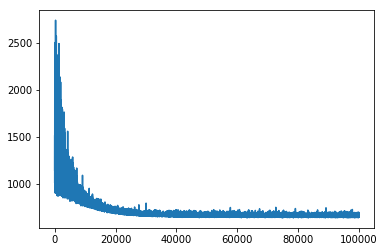

In [116]:
plt.plot(elbo_arr)

In [178]:
def predict(x):
    model_preds = []
    for i in range(len(x)):
        guide_trace = pyro.poutine.trace(guide).get_trace(x,None,x.shape[1])
        replay_result = pyro.poutine.replay(model, guide_trace)(x,None,x.shape[1])
        model_preds.append(replay_result.detach().numpy())
    return model_preds

In [179]:
ypred = predict(X_nuts_test)
# accuracy_score(ypred, y_nuts_test)
print(len(ypred))

320


In [180]:
ypred[0].shape

(320,)

In [196]:
preds = []
for i in range(320):
    preds.append(1 if ypred[i][i]>=0.5 else 0)
acc = accuracy_score(preds,y_nuts_test)